In [1]:
from forced_convection_dft.forward_models import ForwardModelDft, ForwardModelThermocouple
from forced_convection_dft.find_incident_heat_flux import HeatFluxFinder
from dft_inverse_code import dft_models, heat_transfer_coefficients
import numpy as np
import matplotlib.pyplot as plt
import warnings
import plot_settings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Simulation info

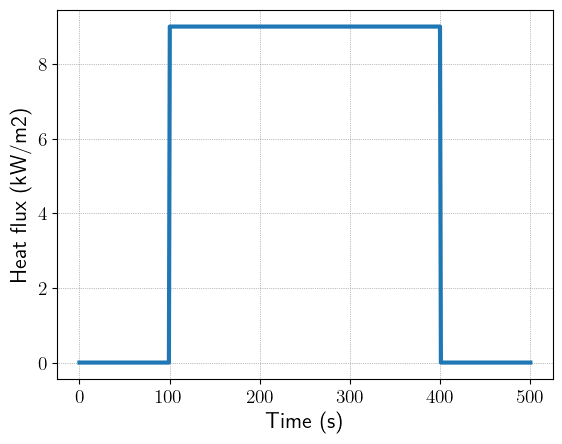

In [12]:
n_points = 500
time_vector = np.linspace(0, 500, n_points)
velocity = np.ones(n_points) * 3.4
temp_init = 21 + 273
temp_surr = 21 + 273
temp_amb = 21 + 273
q_inc = np.ones_like(time_vector) * 9e3
q_inc[time_vector < 100] = 0
q_inc[time_vector > 400] = 0

plt.plot(time_vector, q_inc / 1e3, lw=3)
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m2)');

# Properties

In [13]:
diameter_tc = 1.4e-3
density_tc = 8665
heat_capacity_tc = 485.6 
emissivity_tc = 0.8
alpha_tc = 0.8
dft_thickness =  0.0016
insulation_thickness = .019
plate_side_length = .0762

# Run forward model

In [14]:
forward_dft = ForwardModelDft(n_nodes=10, time=time_vector, insul_thickness=insulation_thickness, plate_thickness=dft_thickness, q_inc=q_inc,
                 characteristic_velocity=velocity, temp_init=temp_init, temp_amb=temp_amb, temp_surr=temp_surr, dft_plate_length=plate_side_length)
temp_f, temp_b, temp_ins, h_f, h_b = forward_dft.run()
forward_tc = ForwardModelThermocouple(time_vector, q_inc, velocity, temp_init,
                 temp_amb, temp_surr, emissivity_tc, alpha_tc, diameter_tc, heat_capacity_tc,
                 density_tc)
temp_tc = forward_tc.run()

100%|██████████| 499/499 [00:00<00:00, 13848.82it/s]


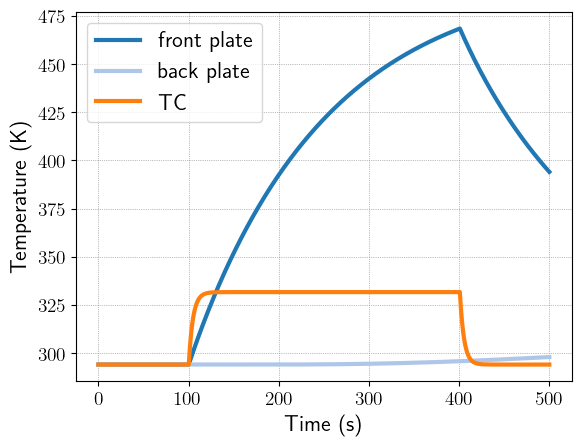

In [36]:
plt.plot(time_vector, temp_f, lw=3, label='front plate')
plt.plot(time_vector, temp_b, lw=3, label='back plate')
plt.plot(time_vector, temp_tc, lw=3, label='TC')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)');

# Recover heat flux

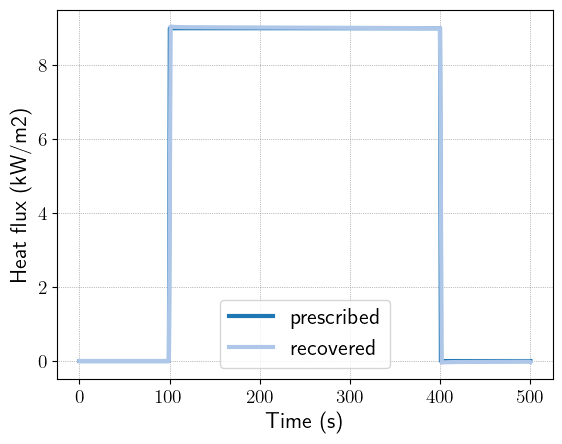

In [16]:
hf_finder = HeatFluxFinder(temp_f, temp_b, temp_tc, temp_amb,
                   temp_init, temp_surr, time_vector, diameter_tc,
                   alpha_tc, alpha_tc, heat_capacity_tc, density_tc, 
                           constant_velocity=True,  
                           plate_side_length=plate_side_length)
plt.plot(time_vector, q_inc / 1e3, lw=3, label='prescribed')
plt.plot(time_vector, hf_finder.find_q_inc(), lw=3, label='recovered')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m2)');

In [17]:
hf_finder.velocity

array([3.41667969])

# Compare with just using natural convection heat transfer coefficient

In [18]:
h_f_nat = heat_transfer_coefficients.natural_convection(
            (temp_f + temp_amb).reshape(-1, 1) / 2, Kelvin=True,
           T_infty=temp_amb).custom(0.65, 0.25).flatten()

In [19]:
q_inc_plate_nat = dft_models.one_dim_conduction(T_f=temp_f, T_b=temp_b, time=time_vector, h_f=h_f_nat, h_b=h_b, model='one_d_conduction', Kelvin=True, T_inf=temp_amb, T_sur=temp_surr).q_inc

q_inc_plate_true = dft_models.one_dim_conduction(T_f=temp_f, T_b=temp_b, time=time_vector, h_f=forward_dft.h_f, h_b=h_b, model='one_d_conduction', Kelvin=True, T_inf=temp_amb, T_sur=temp_surr).q_inc

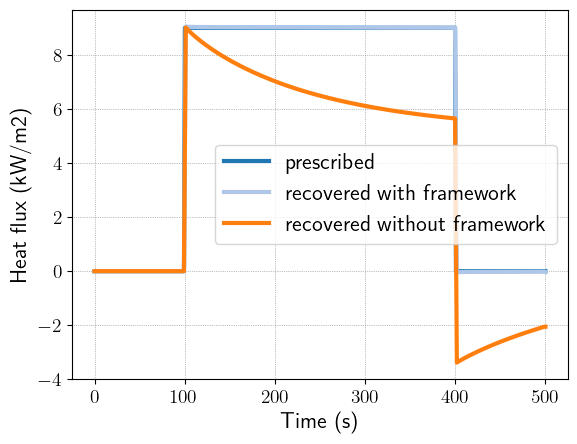

In [20]:
plt.plot(time_vector, q_inc / 1e3, lw=3, label='prescribed')
plt.plot(time_vector, hf_finder.find_q_inc(), lw=3, label='recovered with framework')
plt.plot(time_vector, q_inc_plate_nat, lw=3, label='recovered without framework')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m2)');

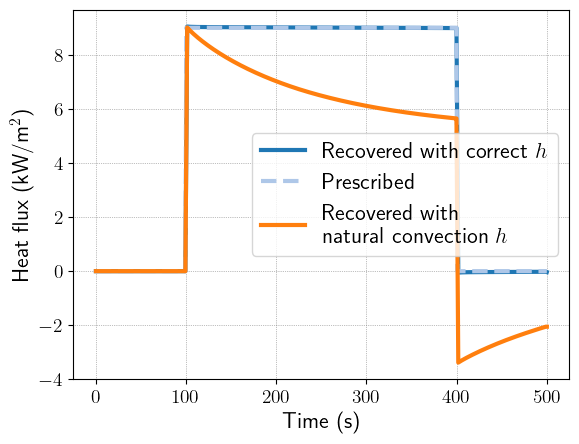

In [42]:
plt.plot(time_vector, q_inc_plate_true, lw=3, label='Recovered with correct $h$')
plt.plot(time_vector, q_inc / 1e3, lw=3, label='Prescribed', linestyle='dashed')
plt.plot(time_vector, q_inc_plate_nat, lw=3, label='Recovered with \n natural convection $h$')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m$^2$)')
plt.savefig('../../dissertation_franqueville/chapters/dft_chapter/figures/fluxes_example.png', dpi=300, bbox_inches='tight')

In [43]:
err = (q_inc_plate_nat - q_inc / 1e3) / (q_inc / 1e3)

In [44]:
np.abs(err[np.isfinite(err)]).mean() * 100

25.196109291430208

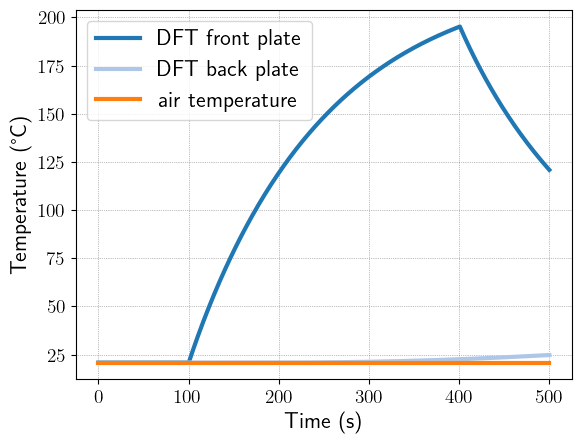

In [45]:
plt.plot(time_vector, temp_f - 273.15, lw=3, label='DFT front plate')
plt.plot(time_vector, temp_b- 273.15, lw=3, label='DFT back plate')
plt.plot(time_vector, temp_amb * np.ones(time_vector.shape[0])- 273.15, lw=3, label='air temperature')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.savefig('../../dissertation_franqueville/chapters/dft_chapter/figures/temps_example.png', dpi=300, bbox_inches='tight')


In [46]:
forward_dft.h_f.mean()

25.856492995858783

In [47]:
h_f_nat.mean()

5.552269622905545